In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
!apt-get install python-dev graphviz libgraphviz-dev pkg-config

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import econml as eml
import shap
from dowhy import CausalModel
from dowhy.datasets import sales_dataset
import causallearn
import ydata_profiling as pp
import networkx as nx
pd.set_option('display.max_columns', None)

**Data generation process**

In [5]:
from scipy.stats import truncexpon, halfnorm


def create_observed_latency_data(unobserved_intrinsic_latencies):
    observed_latencies = {}
    observed_latencies['Product DB'] = unobserved_intrinsic_latencies['Product DB']
    observed_latencies['Customer DB'] = unobserved_intrinsic_latencies['Customer DB']
    observed_latencies['Order DB'] = unobserved_intrinsic_latencies['Order DB']
    observed_latencies['Shipping Cost Service'] = unobserved_intrinsic_latencies['Shipping Cost Service']
    observed_latencies['Caching Service'] = np.random.choice([0, 1], size=(len(observed_latencies['Product DB']),),
                                                             p=[.5, .5]) * \
                                            observed_latencies['Product DB'] \
                                            + unobserved_intrinsic_latencies['Caching Service']
    observed_latencies['Product Service'] = np.maximum(np.maximum(observed_latencies['Shipping Cost Service'],
                                                                  observed_latencies['Caching Service']),
                                                       observed_latencies['Customer DB']) \
                                            + unobserved_intrinsic_latencies['Product Service']
    observed_latencies['Auth Service'] = observed_latencies['Customer DB'] \
                                         + unobserved_intrinsic_latencies['Auth Service']
    observed_latencies['Order Service'] = observed_latencies['Order DB'] \
                                          + unobserved_intrinsic_latencies['Order Service']
    observed_latencies['API'] = observed_latencies['Product Service'] \
                                + observed_latencies['Customer DB'] \
                                + observed_latencies['Auth Service'] \
                                + observed_latencies['Order Service'] \
                                + unobserved_intrinsic_latencies['API']
    observed_latencies['www'] = observed_latencies['API'] \
                                + observed_latencies['Auth Service'] \
                                + unobserved_intrinsic_latencies['www']
    observed_latencies['Website'] = observed_latencies['www'] \
                                    + unobserved_intrinsic_latencies['Website']

    return pd.DataFrame(observed_latencies)


def unobserved_intrinsic_latencies_normal(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }


normal_data = create_observed_latency_data(unobserved_intrinsic_latencies_normal(10000))

In [6]:
normal_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.065053,0.280769,0.126567,0.143199,0.104289,0.489128,0.444925,0.734824,2.499670,3.156089,3.186747
1,0.147077,0.057196,0.088121,0.321540,0.106361,0.549516,0.596010,0.913014,2.887654,3.527964,3.639577
2,0.050433,0.349493,0.201603,0.399752,0.222205,0.778085,0.611637,0.797597,3.469008,4.139244,4.249174
3,0.525044,0.106141,0.071776,0.136722,0.653843,0.922722,0.573248,0.909101,3.117520,3.821641,3.907326
4,0.355131,0.299309,0.171559,0.232199,0.487429,0.590191,0.464745,0.765174,2.796693,3.336559,3.461838


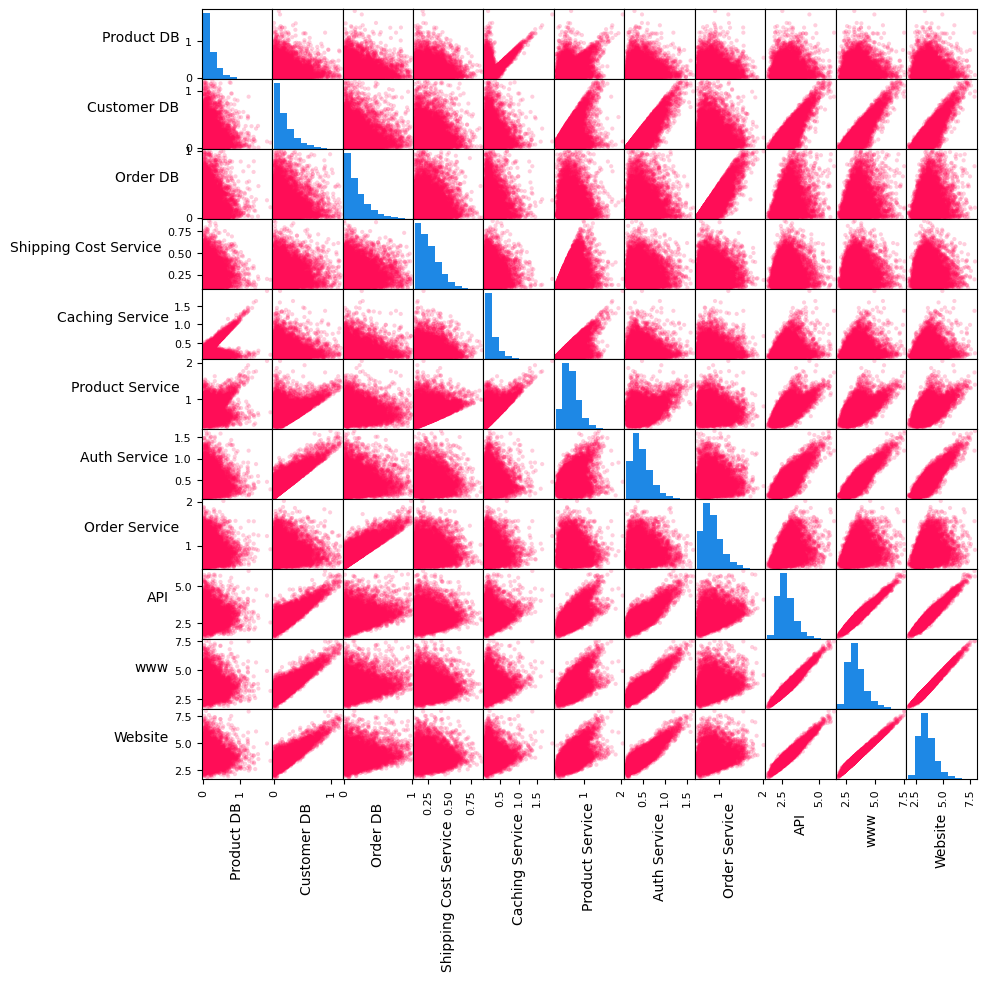

In [7]:
axes = pd.plotting.scatter_matrix(normal_data, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In [8]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

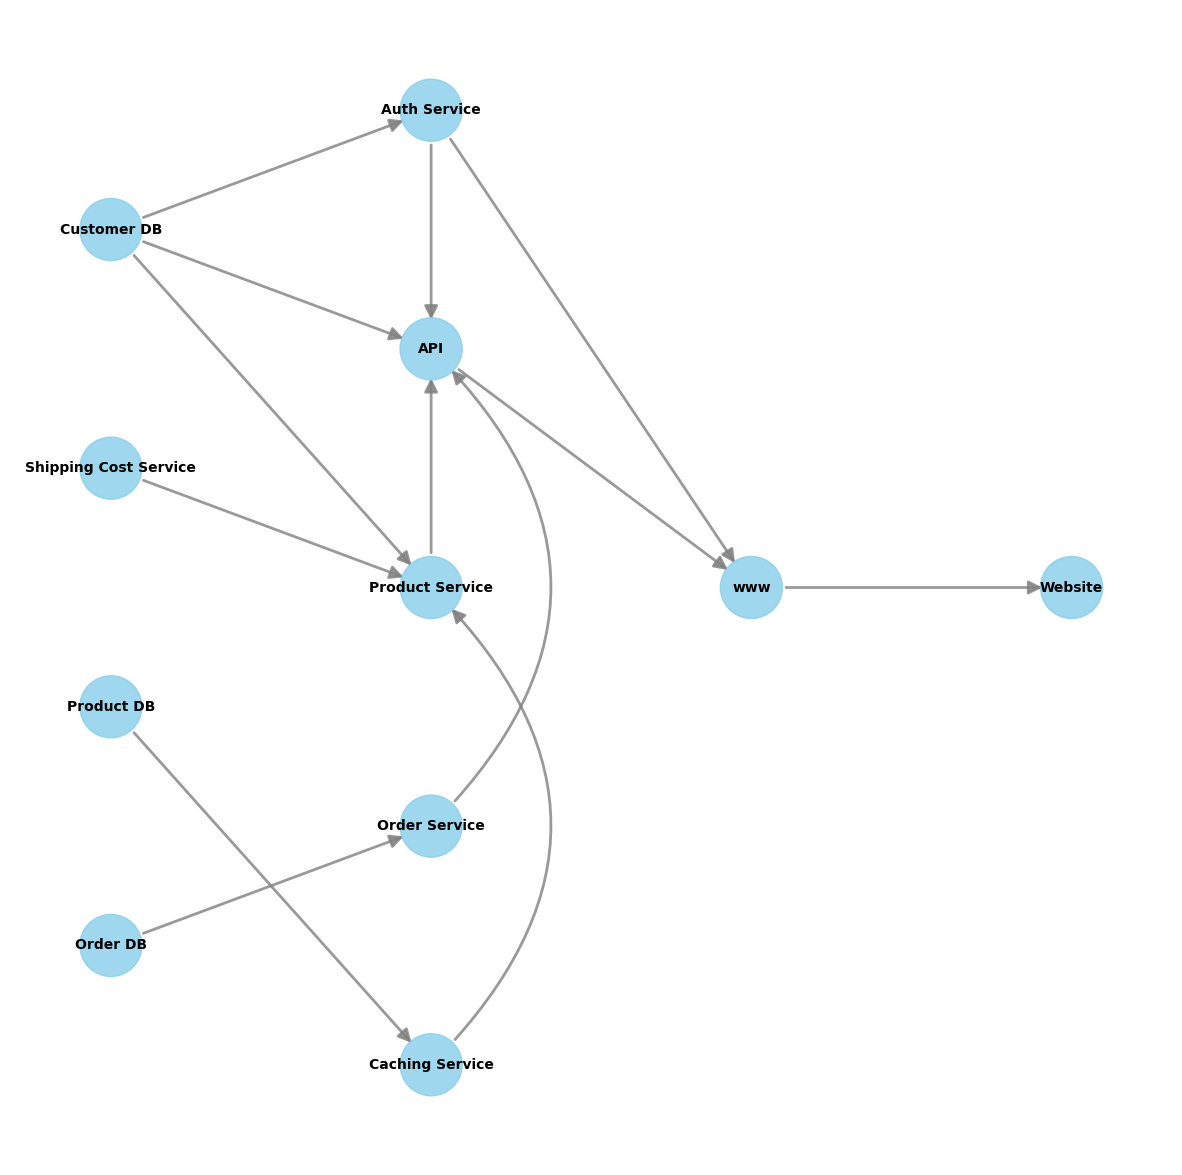

In [22]:
from dowhy.utils import plot, bar_plot
plot(causal_graph, figure_size=[15, 15])

In [10]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

In [11]:
gcm.auto.assign_causal_mechanisms(causal_model, normal_data)

Test permutations of given graph: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


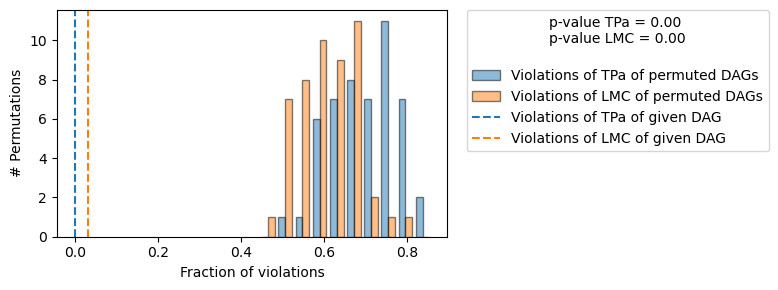

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [12]:
gcm.fit(causal_model, normal_data)
print(gcm.evaluate_causal_model(causal_model, normal_data))

**Scenario 1: Observing a couple of outliers**

In [13]:
# Outlier Data generation 
def unobserved_intrinsic_latencies_anomalous(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': 2 + halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }

outlier_data = create_observed_latency_data(unobserved_intrinsic_latencies_anomalous(1000))

In [14]:
outlier_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.057720,0.401673,0.134046,0.335373,2.103737,2.377875,0.724755,0.658898,4.678889,5.676558,5.751709
1,0.065212,0.281414,0.007905,0.145790,2.114619,2.277273,0.457420,0.911555,4.492963,4.950933,5.271023
2,1.153447,0.193844,0.195952,0.530710,3.372400,3.964411,0.404404,0.768504,6.275394,6.705791,6.951143
3,0.175030,0.098470,0.005303,0.230420,2.166059,2.335384,0.512884,0.696465,4.314241,5.105465,5.480619
4,0.296897,0.269959,0.227372,0.229872,2.481800,2.612381,0.415355,0.751078,4.788122,5.498006,5.604000


In [15]:
# We are interested in the increased latency of Website which the customer directly experienced.
outlier_data.iloc[0]['Website']-normal_data['Website'].mean()

The Website is slower on average (by almost 2 seconds) than usual. Let's see what factors are causing this issue.

In [16]:
outlier_data_sample = outlier_data.sample(10)

In [17]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='Website',
                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=10)

KeyboardInterrupt: 

**Simulating the intervention of shifting resources**

In [18]:
median_mean_latencies, uncertainty_mean_latencies = gcm.confidence_intervals(
    lambda : gcm.fit_and_compute(gcm.interventional_samples,
                                 causal_model,
                                 outlier_data,
                                 interventions = {
                                    "Caching Service": lambda x: x-1,
                                    "Shipping Cost Service": lambda x: x+2
                                 },
                                 observed_data=outlier_data)().mean().to_dict(),
    num_bootstrap_resamples=10)

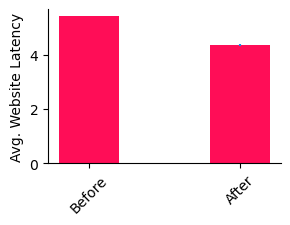

In [19]:
avg_website_latency_before = outlier_data.mean().to_dict()['Website']
bar_plot(dict(before=avg_website_latency_before, after=median_mean_latencies['Website']),
                  dict(before=np.array([avg_website_latency_before, avg_website_latency_before]), after=uncertainty_mean_latencies['Website']),
                  ylabel='Avg. Website Latency',
                  figure_size=(3, 2),
                  bar_width=0.4,
                  xticks=['Before', 'After'],
                  xticks_rotation=45)

We achieved an improvement of approximately 1 second. While we're not yet back to normal operation, we have alleviated a portion of the issue.